<a href="https://colab.research.google.com/github/ahoorarstmn/PyTorch_DL_FaraDars/blob/main/11_PyTorch_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Adversarial Networks**
* [Generative Adversarial Networks](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)


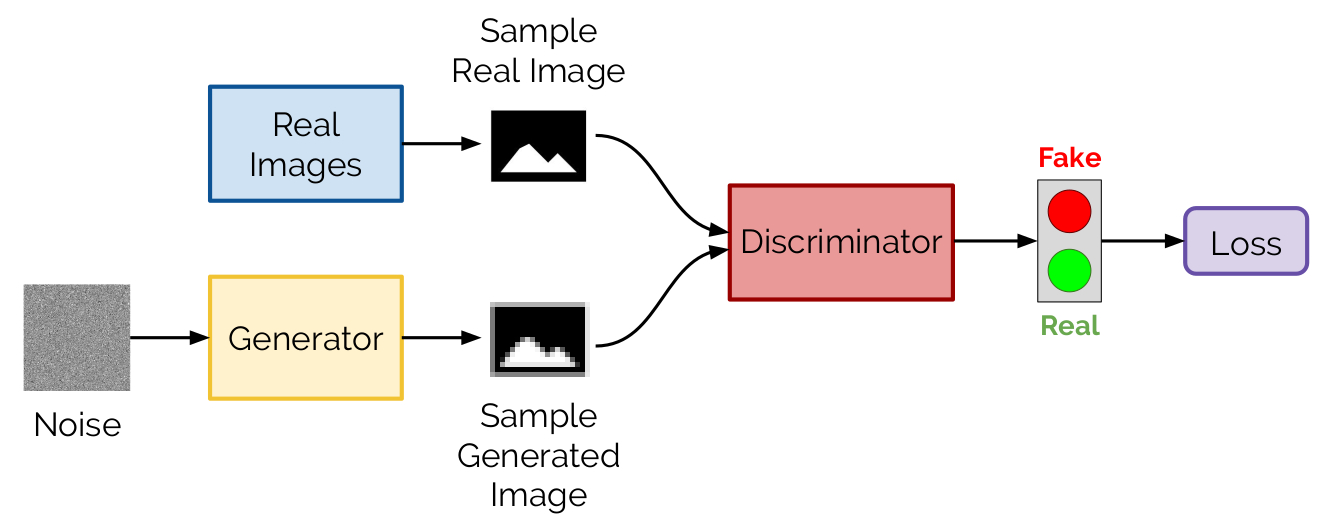

## **Deep Convolutional Generative Adversarial Network**

* [Unsupervised Representation Learning with Deep Convolutional Adversarial Networks](https://arxiv.org/pdf/1511.06434v1.pdf)


**Generator Architecture**

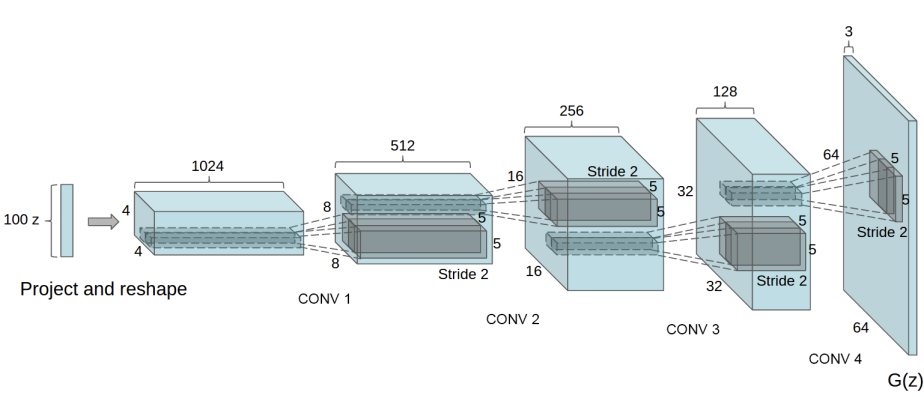

**Guidelines for stable Deep Convolutional GANs:**

*   Replace any pooling layers with strided convolutions    (discriminator) and fractional-strided
convolutions (generator).
*   Use batchnorm in both the generator and the discriminator.
*   Remove fully connected hidden layers for deeper architectures.
*   Use ReLU activation in generator for all layers except for the output, which uses Tanh.
*   Use LeakyReLU activation in the discriminator for all layers



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
z_dim = 100 # 100-dimensional noise vector as the input to Generator
num_epochs = 3
learning_rate = 0.0002 # Optimizer learning rate
beta1 = 0.5 # Momentum value for Adam optimizer

## **Dataset**


In [ ]:
# Zipped dataset(CelebA) is stored on google drive. 
# Dataset URL: https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg

with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/FaraDars PyTorch/Data/img_align_celeba.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/celeba')


In [ ]:
root = '/content/data/celeba'
dataset = datasets.ImageFolder(root=root,
                               transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=True, num_workers=8)

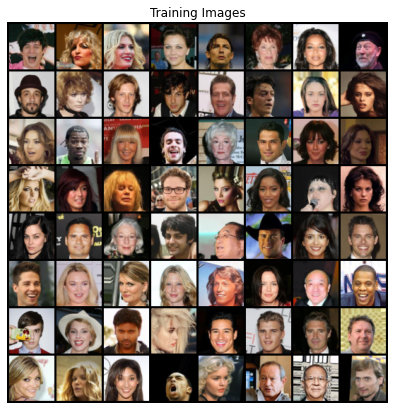

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(7, 7))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=3, normalize=True).cpu(),(1, 2, 0)));

## **Model Implementation**

### Weight Initialization

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(m.bias, val=0)

### Discriminator Model

In [ ]:
discriminator = nn.Sequential(
    

    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Sigmoid())

disc = discriminator.to(device)
disc.apply(init_weights)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)

### Generator Model

In [ ]:
generator = nn.Sequential(

    nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

gen = generator.to(device)
gen.apply(init_weights)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

## **Training**


### Criterion and Optimizers

In [ ]:
criterion = nn.BCELoss()
disc_optim = optim.Adam(disc.parameters(), lr=learning_rate, betas=(beta1, 0.999))
gen_optim = optim.Adam(gen.parameters(), lr=learning_rate, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)
real_label = 1.
fake_label = 0.

### Training Loop

In [ ]:
D_losses = []
G_losses = []
img_list = []
iters = 0


for epoch in range(num_epochs):

    for i, batch in enumerate(dataloader):

        disc.zero_grad()
        real_images = batch[0].to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = disc(real_images).view(-1) # Pass train images (real) to the disc.
        disc_error_real = criterion(output, label)
        disc_error_real.backward()

        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake = gen(noise)
        label.fill_(fake_label)
        output = disc(fake.detach()).view(-1) # Pass fake images to the disc.
        disc_error_fake = criterion(output, label)
        disc_error_fake.backward() # Backprop
        disc_error = disc_error_real + disc_error_fake
        disc_optim.step() # Update disc

        gen.zero_grad()
        label.fill_(real_label)
        output = disc(fake).view(-1) # Pass fake images to the update disc.
        gen_error = criterion(output, label) # Gen loss based on the cases in which disc is wrong.
        gen_error.backward() # Backprop
        gen_optim.step() # Update gen

        if i % 200 == 0:
            print(f'Epoch{[epoch+1]} | Batch[{i}/{len(dataloader)}] | Disc-Loss: {disc_error.item():.4f} | Gen-Loss: {gen_error.item():.4f}')
        
                
        G_losses.append(gen_error.item())
        D_losses.append(disc_error.item())

        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Epoch[1] | Batch[0/1583] | Disc-Loss: 1.4599 | Gen-Loss: 2.5662
Epoch[1] | Batch[200/1583] | Disc-Loss: 0.7138 | Gen-Loss: 4.1487
Epoch[1] | Batch[400/1583] | Disc-Loss: 0.7142 | Gen-Loss: 1.9672
Epoch[1] | Batch[600/1583] | Disc-Loss: 1.2513 | Gen-Loss: 2.2433
Epoch[1] | Batch[800/1583] | Disc-Loss: 0.8082 | Gen-Loss: 2.8562
Epoch[1] | Batch[1000/1583] | Disc-Loss: 0.3775 | Gen-Loss: 4.0368
Epoch[1] | Batch[1200/1583] | Disc-Loss: 0.5421 | Gen-Loss: 5.3636
Epoch[1] | Batch[1400/1583] | Disc-Loss: 1.2380 | Gen-Loss: 5.1147
Epoch[2] | Batch[0/1583] | Disc-Loss: 0.8478 | Gen-Loss: 4.0022
Epoch[2] | Batch[200/1583] | Disc-Loss: 0.5127 | Gen-Loss: 2.7035
Epoch[2] | Batch[400/1583] | Disc-Loss: 0.4552 | Gen-Loss: 2.1091
Epoch[2] | Batch[600/1583] | Disc-Loss: 0.5662 | Gen-Loss: 2.2993
Epoch[2] | Batch[800/1583] | Disc-Loss: 0.4029 | Gen-Loss: 3.5178
Epoch[2] | Batch[1000/1583] | Disc-Loss: 0.4168 | Gen-Loss: 3.7934
Epoch[2] | Batch[1200/1583] | Disc-Loss: 0.7127 | Gen-Loss: 5.1279
Epoch[2] 

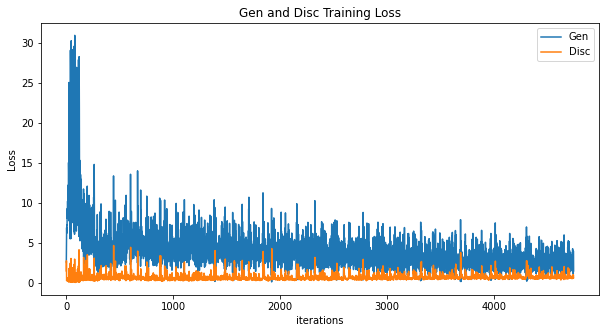

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Gen and Disc Training Loss")
plt.plot(G_losses,label="Gen")
plt.plot(D_losses,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

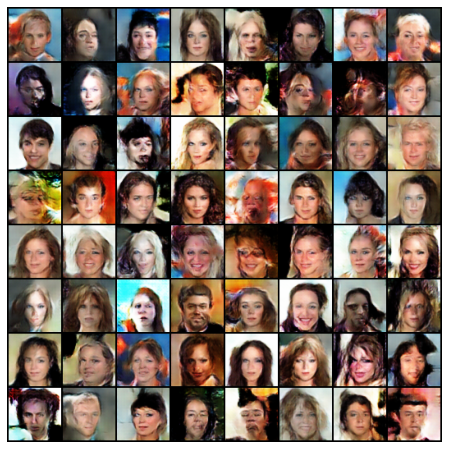

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
imgs = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())